# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [4]:
# Define the model
# Define model
#weights = models.ResNet50_Weights.IMAGENET1K_V2
#model = models.resnet50(weights=weights)
#transforms = weights.transforms()
weights = models.ResNet152_Weights.IMAGENET1K_V2
model = models.resnet152(weights=weights)
transforms = weights.transforms()

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [5]:
# Normalize images
data_aug = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

data_in = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

'transforms.Compose([\n    transforms.ToImage(),\n    transforms.Resize((256, 256)),\n    transforms.CenterCrop((224, 224)),\n    transforms.ToDtype(torch.float32, scale=True),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])'

In [6]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    col = 7-col
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        #restrict ther the number of filenames to 10
        self.ids = np.asarray(self.ids)
        self.boards=torch.zeros((len(self.file_names), 8,8, 13), dtype=torch.float32)
        for i in range(8):
            for j in range(8):
                self.boards[:, i, j, 12] = 1 # initialize empty board with 1s for empty squares
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            piceId =piece['category_id']
            self.boards[idx][row][col][12] =0
            self.boards[idx][row][col][piceId] =1
        #print(self.boards[0])
        if partition == 'train':#['chessred2k']
            self.split_ids = np.asarray(self.anns['splits']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.file_names = self.file_names#[:45]
        #self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        board = self.boards[self.split_ids[i]]
        #print("Board shape:",board.shape)
        return image, board

train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)


Number of train images: 6479
Number of valid images: 2192


In [7]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 16
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


torch.Size([16, 224, 224, 3])
['-', '-', '-', 'B', '-', '-', '-', '-']
['P', '-', '-', '-', '-', '-', 'P', '-']
['-', '-', 'K', '-', 'P', '-', '-', '-']
['q', '-', '-', '-', 'p', 'P', 'p', '-']
['-', '-', '-', 'Q', '-', 'p', '-', '-']
['-', 'p', 'P', '-', '-', '-', '-', '-']
['-', '-', 'p', '-', '-', '-', '-', '-']
['b', 'k', '-', '-', '-', '-', '-', '-']


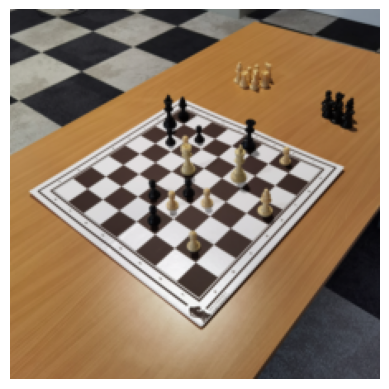

In [8]:
def convert_to_redable(labels):
    result = []
    for i in range(8):
        result_tmp = []
        for j in range(8):
            result_tmp.append(int(torch.argmax(labels[i][j])))
        result.append(result_tmp)
    return result
def print_readable_board(labels):
    piece_dict = {
    0: "P",
    1: "R",
    2: "N",
    3: "B",
    4: "Q",
    5: "K",
    6: "p",
    7: "r",
    8: "n",
    9: "b",
    10:"q",
    11: "k",
    12: "-"
}
    for i in range(8):
        result_tmp = []
        for j in range(8):
            result_tmp.append(piece_dict[int(torch.argmax(labels[i][j]))])
        print(result_tmp)


for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print_readable_board(labels[0])
    #print(torch.argmax(labels[0])+1)
    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break


## Defining the model

We will use a pre-trained ResNet50 network.

  1: white-pawn
  2: white-pawn
  3: white-pawn
  4: white-pawn
  5: white-pawn
  6: white-pawn
  7: white-pawn
  8: white-pawn
  9: white-rook
  10: white-rook
  11: white-knight
  12: white-knight
  13: white-bishop
  14: white-bishop
  15: white-queen
  16: white-king
  17: black-pawn
  18: black-pawn
  19: black-pawn
  20: black-pawn
  21: black-pawn
  22: black-pawn
  23: black-pawn
  24: black-pawn
  25: black-rook
  26: black-rook
  27: black-knight
  28: black-knight
  29: black-bishop
  30: black-bishop
  31: black-king
  32: black-queen
  12: empty

In [9]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
# MLP
size_parameters = 512
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, size_parameters),
    nn.ReLU(),
    nn.Linear(size_parameters, 832), # 13 pieces types 8*8*13
    nn.Sigmoid()
)
# black 
model.to(device)

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Train the model

Define function to perform one iteration

In [10]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device).float() # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          batch_size = X.size(0)
          formated_pred = pred.view(batch_size, 8, 8, 13)
          #scaled_pred = model(X)
          #print(fomated_pred.shape,y.shape)
          #print(fomated_pred,y)
          loss = loss_fn(formated_pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          preds.extend(formated_pred.cpu())
          #print(preds)
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.extend(y.cpu())
    all_preds = torch.cat(preds)
    all_labels = torch.cat(labels)
    # Suggested fix:
    all_preds = all_preds.argmax(dim=-1)
    all_labels = all_labels.argmax(dim=-1)
    correct = (all_preds == all_labels).sum().item()
    total = all_labels.numel()
    #print("Testing:",correct,"\nTotal:",total)
    accuracy = correct / total
    #print("Accuracy:", accuracy)
    """print(all_preds.shape,all_labels.shape)
    print(all_preds,all_labels)
      # Calculate exact match accuracy (PyTorch way)
    exact_matches = (all_preds == all_labels).all(dim=1).float().mean().item()
    
    # Calculate element-wise accuracy
    element_acc = (all_preds == all_labels).float().mean().item()
    print(exact_matches,element_acc)"""
    
    return total_loss / num_batches, accuracy

Define function to train a model

In [11]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f}")
      val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      
  print("Finished")
  return train_history, val_history

Define loss, optimizer and train the model

In [12]:
# Define loss function
#loss_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 100

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 404/404 [01:29<00:00,  4.54it/s]


Train loss: 1.16926 	 Train acc: 0.22322


100%|██████████| 137/137 [00:09<00:00, 13.90it/s]


Val loss: 1.18264 	 Val acc: 0.22393

Epoch 2


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.15908 	 Train acc: 0.26506


100%|██████████| 137/137 [00:09<00:00, 13.94it/s]


Val loss: 1.18051 	 Val acc: 0.23949

Epoch 3


100%|██████████| 404/404 [01:27<00:00,  4.59it/s]


Train loss: 1.15501 	 Train acc: 0.27611


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17380 	 Val acc: 0.26195

Epoch 4


100%|██████████| 404/404 [01:28<00:00,  4.59it/s]


Train loss: 1.15159 	 Train acc: 0.28669


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17162 	 Val acc: 0.26838

Epoch 5


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.14973 	 Train acc: 0.28842


100%|██████████| 137/137 [00:09<00:00, 13.86it/s]


Val loss: 1.17240 	 Val acc: 0.26268

Epoch 6


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.14739 	 Train acc: 0.28328


100%|██████████| 137/137 [00:09<00:00, 13.94it/s]


Val loss: 1.17259 	 Val acc: 0.26379

Epoch 7


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.14341 	 Train acc: 0.29412


100%|██████████| 137/137 [00:09<00:00, 13.93it/s]


Val loss: 1.17237 	 Val acc: 0.26967

Epoch 8


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.13968 	 Train acc: 0.30423


100%|██████████| 137/137 [00:09<00:00, 13.95it/s]


Val loss: 1.17114 	 Val acc: 0.28193

Epoch 9


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.13522 	 Train acc: 0.31261


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17044 	 Val acc: 0.28904

Epoch 10


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.13112 	 Train acc: 0.32597


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17165 	 Val acc: 0.30725

Epoch 11


100%|██████████| 404/404 [01:27<00:00,  4.59it/s]


Train loss: 1.12587 	 Train acc: 0.34225


100%|██████████| 137/137 [00:09<00:00, 13.95it/s]


Val loss: 1.17259 	 Val acc: 0.31503

Epoch 12


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.12004 	 Train acc: 0.35381


100%|██████████| 137/137 [00:09<00:00, 13.87it/s]


Val loss: 1.17285 	 Val acc: 0.33344

Epoch 13


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.11472 	 Train acc: 0.37348


100%|██████████| 137/137 [00:09<00:00, 13.94it/s]


Val loss: 1.17508 	 Val acc: 0.34229

Epoch 14


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.10938 	 Train acc: 0.38930


100%|██████████| 137/137 [00:09<00:00, 13.90it/s]


Val loss: 1.17356 	 Val acc: 0.35486

Epoch 15


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.10376 	 Train acc: 0.41397


100%|██████████| 137/137 [00:09<00:00, 13.98it/s]


Val loss: 1.17670 	 Val acc: 0.36407

Epoch 16


100%|██████████| 404/404 [01:27<00:00,  4.59it/s]


Train loss: 1.09836 	 Train acc: 0.43195


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17594 	 Val acc: 0.37641

Epoch 17


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.09417 	 Train acc: 0.44876


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17584 	 Val acc: 0.37384

Epoch 18


100%|██████████| 404/404 [01:27<00:00,  4.59it/s]


Train loss: 1.09039 	 Train acc: 0.46258


100%|██████████| 137/137 [00:09<00:00, 13.94it/s]


Val loss: 1.17585 	 Val acc: 0.39551

Epoch 19


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.08672 	 Train acc: 0.47138


100%|██████████| 137/137 [00:09<00:00, 13.93it/s]


Val loss: 1.17650 	 Val acc: 0.39089

Epoch 20


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.08389 	 Train acc: 0.48440


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17892 	 Val acc: 0.40915

Epoch 21


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.08101 	 Train acc: 0.49475


100%|██████████| 137/137 [00:09<00:00, 13.88it/s]


Val loss: 1.17704 	 Val acc: 0.40711

Epoch 22


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.07874 	 Train acc: 0.50079


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17690 	 Val acc: 0.41180

Epoch 23


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.07670 	 Train acc: 0.50842


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17585 	 Val acc: 0.41842

Epoch 24


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.07531 	 Train acc: 0.51410


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17835 	 Val acc: 0.41647

Epoch 25


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.07349 	 Train acc: 0.52032


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17569 	 Val acc: 0.42182

Epoch 26


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.07199 	 Train acc: 0.52739


100%|██████████| 137/137 [00:09<00:00, 13.95it/s]


Val loss: 1.17599 	 Val acc: 0.43221

Epoch 27


100%|██████████| 404/404 [01:27<00:00,  4.59it/s]


Train loss: 1.07071 	 Train acc: 0.53256


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17723 	 Val acc: 0.43409

Epoch 28


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.06990 	 Train acc: 0.53663


100%|██████████| 137/137 [00:09<00:00, 13.85it/s]


Val loss: 1.17794 	 Val acc: 0.43135

Epoch 29


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.06881 	 Train acc: 0.54089


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17917 	 Val acc: 0.43119

Epoch 30


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.06769 	 Train acc: 0.54425


100%|██████████| 137/137 [00:09<00:00, 13.94it/s]


Val loss: 1.18037 	 Val acc: 0.44339

Epoch 31


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.06734 	 Train acc: 0.54941


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17756 	 Val acc: 0.44691

Epoch 32


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.06601 	 Train acc: 0.55166


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17703 	 Val acc: 0.44555

Epoch 33


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.06517 	 Train acc: 0.55480


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17811 	 Val acc: 0.44270

Epoch 34


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.06481 	 Train acc: 0.55603


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17751 	 Val acc: 0.44332

Epoch 35


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.06408 	 Train acc: 0.55882


100%|██████████| 137/137 [00:09<00:00, 13.87it/s]


Val loss: 1.17833 	 Val acc: 0.45115

Epoch 36


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.06355 	 Train acc: 0.56252


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.18048 	 Val acc: 0.44695

Epoch 37


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.06331 	 Train acc: 0.56398


100%|██████████| 137/137 [00:09<00:00, 13.90it/s]


Val loss: 1.17772 	 Val acc: 0.45308

Epoch 38


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.06234 	 Train acc: 0.56518


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17937 	 Val acc: 0.44950

Epoch 39


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.06233 	 Train acc: 0.56673


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17795 	 Val acc: 0.45236

Epoch 40


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.06153 	 Train acc: 0.56867


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17768 	 Val acc: 0.45276

Epoch 41


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.06092 	 Train acc: 0.56942


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17845 	 Val acc: 0.45108

Epoch 42


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.06061 	 Train acc: 0.57032


100%|██████████| 137/137 [00:09<00:00, 13.93it/s]


Val loss: 1.17838 	 Val acc: 0.45687

Epoch 43


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.06029 	 Train acc: 0.57012


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17728 	 Val acc: 0.46298

Epoch 44


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05984 	 Train acc: 0.57169


100%|██████████| 137/137 [00:09<00:00, 13.86it/s]


Val loss: 1.17822 	 Val acc: 0.44833

Epoch 45


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.06001 	 Train acc: 0.57206


100%|██████████| 137/137 [00:09<00:00, 13.95it/s]


Val loss: 1.17727 	 Val acc: 0.45965

Epoch 46


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05917 	 Train acc: 0.57255


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17830 	 Val acc: 0.45977

Epoch 47


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05899 	 Train acc: 0.57437


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17894 	 Val acc: 0.45973

Epoch 48


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05924 	 Train acc: 0.57564


100%|██████████| 137/137 [00:09<00:00, 13.94it/s]


Val loss: 1.17871 	 Val acc: 0.45723

Epoch 49


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05885 	 Train acc: 0.57713


100%|██████████| 137/137 [00:09<00:00, 13.95it/s]


Val loss: 1.17817 	 Val acc: 0.46013

Epoch 50


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05814 	 Train acc: 0.57779


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17730 	 Val acc: 0.46285

Epoch 51


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05789 	 Train acc: 0.57692


100%|██████████| 137/137 [00:09<00:00, 13.87it/s]


Val loss: 1.17824 	 Val acc: 0.46699

Epoch 52


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05789 	 Train acc: 0.57681


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17792 	 Val acc: 0.46169

Epoch 53


100%|██████████| 404/404 [01:27<00:00,  4.59it/s]


Train loss: 1.05787 	 Train acc: 0.57829


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17834 	 Val acc: 0.46200

Epoch 54


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05717 	 Train acc: 0.57725


100%|██████████| 137/137 [00:09<00:00, 13.95it/s]


Val loss: 1.17967 	 Val acc: 0.46124

Epoch 55


100%|██████████| 404/404 [01:27<00:00,  4.59it/s]


Train loss: 1.05732 	 Train acc: 0.57800


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17961 	 Val acc: 0.46169

Epoch 56


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05678 	 Train acc: 0.57704


100%|██████████| 137/137 [00:09<00:00, 13.95it/s]


Val loss: 1.17861 	 Val acc: 0.46086

Epoch 57


100%|██████████| 404/404 [01:27<00:00,  4.59it/s]


Train loss: 1.05675 	 Train acc: 0.57627


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17863 	 Val acc: 0.46045

Epoch 58


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05678 	 Train acc: 0.57390


100%|██████████| 137/137 [00:09<00:00, 13.86it/s]


Val loss: 1.17887 	 Val acc: 0.45828

Epoch 59


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05617 	 Train acc: 0.57833


100%|██████████| 137/137 [00:09<00:00, 13.95it/s]


Val loss: 1.17781 	 Val acc: 0.46214

Epoch 60


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05638 	 Train acc: 0.57610


100%|██████████| 137/137 [00:09<00:00, 13.93it/s]


Val loss: 1.17719 	 Val acc: 0.45903

Epoch 61


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05611 	 Train acc: 0.57747


100%|██████████| 137/137 [00:09<00:00, 13.94it/s]


Val loss: 1.17879 	 Val acc: 0.46620

Epoch 62


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05589 	 Train acc: 0.57733


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17828 	 Val acc: 0.46282

Epoch 63


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05583 	 Train acc: 0.57674


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17784 	 Val acc: 0.46259

Epoch 64


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05565 	 Train acc: 0.57510


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17868 	 Val acc: 0.45825

Epoch 65


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05558 	 Train acc: 0.57479


100%|██████████| 137/137 [00:09<00:00, 13.92it/s]


Val loss: 1.18050 	 Val acc: 0.46568

Epoch 66


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05511 	 Train acc: 0.57646


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17876 	 Val acc: 0.46726

Epoch 67


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05494 	 Train acc: 0.57689


100%|██████████| 137/137 [00:09<00:00, 13.86it/s]


Val loss: 1.17821 	 Val acc: 0.47011

Epoch 68


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05508 	 Train acc: 0.57683


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17899 	 Val acc: 0.46246

Epoch 69


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05493 	 Train acc: 0.57451


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17807 	 Val acc: 0.46202

Epoch 70


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05482 	 Train acc: 0.57876


100%|██████████| 137/137 [00:09<00:00, 13.95it/s]


Val loss: 1.17795 	 Val acc: 0.46772

Epoch 71


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05473 	 Train acc: 0.57721


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17736 	 Val acc: 0.46234

Epoch 72


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05437 	 Train acc: 0.57812


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17845 	 Val acc: 0.46233

Epoch 73


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05451 	 Train acc: 0.57700


100%|██████████| 137/137 [00:09<00:00, 13.92it/s]


Val loss: 1.17850 	 Val acc: 0.46298

Epoch 74


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05423 	 Train acc: 0.57490


100%|██████████| 137/137 [00:09<00:00, 13.87it/s]


Val loss: 1.17773 	 Val acc: 0.46334

Epoch 75


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05424 	 Train acc: 0.57588


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17691 	 Val acc: 0.46747

Epoch 76


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05405 	 Train acc: 0.57785


100%|██████████| 137/137 [00:09<00:00, 13.95it/s]


Val loss: 1.17751 	 Val acc: 0.46015

Epoch 77


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05394 	 Train acc: 0.57810


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17787 	 Val acc: 0.46769

Epoch 78


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05417 	 Train acc: 0.57748


100%|██████████| 137/137 [00:09<00:00, 13.94it/s]


Val loss: 1.17917 	 Val acc: 0.46224

Epoch 79


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05376 	 Train acc: 0.57609


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17726 	 Val acc: 0.46752

Epoch 80


100%|██████████| 404/404 [01:27<00:00,  4.59it/s]


Train loss: 1.05369 	 Train acc: 0.57824


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17777 	 Val acc: 0.46624

Epoch 81


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05385 	 Train acc: 0.57882


100%|██████████| 137/137 [00:09<00:00, 13.85it/s]


Val loss: 1.17872 	 Val acc: 0.47000

Epoch 82


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05345 	 Train acc: 0.57882


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17803 	 Val acc: 0.46918

Epoch 83


100%|██████████| 404/404 [01:27<00:00,  4.59it/s]


Train loss: 1.05381 	 Train acc: 0.57739


100%|██████████| 137/137 [00:09<00:00, 13.93it/s]


Val loss: 1.17796 	 Val acc: 0.46928

Epoch 84


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05319 	 Train acc: 0.57655


100%|██████████| 137/137 [00:09<00:00, 13.94it/s]


Val loss: 1.17776 	 Val acc: 0.47299

Epoch 85


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05302 	 Train acc: 0.57962


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17834 	 Val acc: 0.46318

Epoch 86


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05294 	 Train acc: 0.57776


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17922 	 Val acc: 0.46911

Epoch 87


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05320 	 Train acc: 0.57830


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.18034 	 Val acc: 0.46621

Epoch 88


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05325 	 Train acc: 0.57547


100%|██████████| 137/137 [00:09<00:00, 13.90it/s]


Val loss: 1.17955 	 Val acc: 0.46464

Epoch 89


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05285 	 Train acc: 0.57685


100%|██████████| 137/137 [00:09<00:00, 13.98it/s]


Val loss: 1.17763 	 Val acc: 0.46374

Epoch 90


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05302 	 Train acc: 0.57684


100%|██████████| 137/137 [00:09<00:00, 13.87it/s]


Val loss: 1.17978 	 Val acc: 0.46864

Epoch 91


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05299 	 Train acc: 0.57585


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17842 	 Val acc: 0.47136

Epoch 92


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05268 	 Train acc: 0.57494


100%|██████████| 137/137 [00:09<00:00, 13.97it/s]


Val loss: 1.17871 	 Val acc: 0.46717

Epoch 93


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05262 	 Train acc: 0.57484


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17813 	 Val acc: 0.46941

Epoch 94


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05261 	 Train acc: 0.57505


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17766 	 Val acc: 0.46621

Epoch 95


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05258 	 Train acc: 0.57223


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17810 	 Val acc: 0.46579

Epoch 96


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05220 	 Train acc: 0.57486


100%|██████████| 137/137 [00:09<00:00, 13.80it/s]


Val loss: 1.17883 	 Val acc: 0.46598

Epoch 97


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05212 	 Train acc: 0.57233


100%|██████████| 137/137 [00:09<00:00, 13.86it/s]


Val loss: 1.17748 	 Val acc: 0.46543

Epoch 98


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05217 	 Train acc: 0.57424


100%|██████████| 137/137 [00:09<00:00, 13.94it/s]


Val loss: 1.17791 	 Val acc: 0.46303

Epoch 99


100%|██████████| 404/404 [01:27<00:00,  4.59it/s]


Train loss: 1.05223 	 Train acc: 0.57321


100%|██████████| 137/137 [00:09<00:00, 13.95it/s]


Val loss: 1.17822 	 Val acc: 0.45982

Epoch 100


100%|██████████| 404/404 [01:27<00:00,  4.60it/s]


Train loss: 1.05222 	 Train acc: 0.57219


100%|██████████| 137/137 [00:09<00:00, 13.96it/s]


Val loss: 1.17697 	 Val acc: 0.45995
Finished


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [13]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

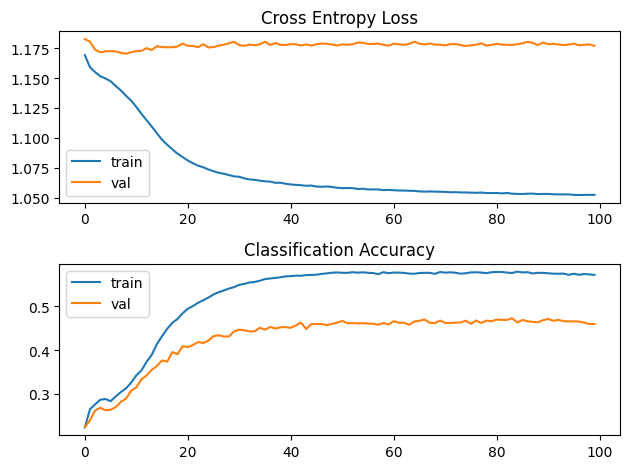

In [14]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [ ]:
# Load the best model
# TODO


# Evaluate model on test data
# TODO
#free cuda memory
torch.cuda.empty_cache()
del valid_dataset, valid_dataloader, train_dataset, train_dataloader
test_dataset = ChessDataset('..', 'test', data_in)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
def test(dataloader):
    preds = []
    labels = []
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        batch_size = X.size(0)
        formated_pred = pred.view(batch_size, 8, 8, 13)
        #probs = F.softmax(pred, dim=1)
        #final_pred = torch.argmax(probs, dim=1)
        preds.extend(formated_pred.cpu())
        #print(preds)
        #print(final_pred.cpu().numpy())
        #original_values =y.cpu().argmax(dim=-1) + 1
        labels.extend(y.cpu())
    all_preds = torch.cat(preds)
    all_labels = torch.cat(labels)
    all_preds = all_preds.argmax(dim=-1)
    all_labels = all_labels.argmax(dim=-1)
    correct = (all_preds == all_labels).sum().item()
    total = all_labels.numel()
    accuracy = correct / total
    return accuracy
test_loss = test(test_dataloader)
print(f"Test loss: {test_loss:.3f}")

Number of test images: 2129


  4%|▍         | 6/134 [00:09<03:15,  1.53s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB. GPU 0 has a total capacity of 12.00 GiB of which 0 bytes is free. Of the allocated memory 17.41 GiB is allocated by PyTorch, and 1.23 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

  0%|          | 0/3 [00:00<?, ?it/s]

['R', 'K', 'B', 'K', 'Q', 'B', 'K', 'R']
['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'k', 'b', 'k', 'q', 'b', 'k', 'r']
Test : torch.Size([8, 8, 13])
['P', '-', 'R', '-', 'Q', 'B', '-', 'R']
['P', 'B', '-', 'P', 'P', '-', 'P', '-']
['-', 'P', 'K', '-', 'P', '-', '-', '-']
['-', '-', 'P', '-', '-', '-', 'P', '-']
['-', '-', '-', 'P', 'p', 'p', '-', '-']
['-', 'p', '-', 'p', '-', 'P', '-', '-']
['p', 'b', 'p', 'k', '-', '-', 'P', 'P']
['-', 'k', 'P', '-', 'q', 'b', 'P', 'P']


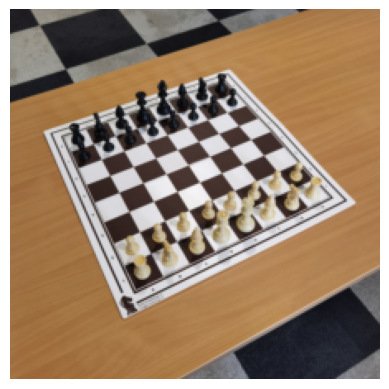

 33%|███▎      | 1/3 [00:00<00:00,  5.78it/s]

['R', '-', '-', 'K', 'Q', '-', '-', 'R']
['P', 'P', 'P', 'B', 'P', '-', 'B', '-']
['-', '-', 'K', 'P', '-', 'K', '-', 'P']
['-', '-', '-', '-', '-', 'P', 'P', '-']
['-', '-', 'b', '-', 'p', '-', '-', '-']
['-', '-', 'k', 'p', 'b', 'p', '-', '-']
['p', 'p', 'p', '-', 'k', '-', 'p', 'p']
['r', '-', '-', 'k', 'q', '-', '-', 'r']
Test : torch.Size([8, 8, 13])
['P', '-', 'R', '-', 'Q', 'B', '-', 'R']
['P', 'B', '-', 'P', 'P', 'P', 'P', '-']
['-', 'P', 'K', '-', 'P', '-', '-', '-']
['-', '-', 'P', '-', '-', '-', 'P', '-']
['-', '-', '-', 'P', 'p', 'p', '-', '-']
['-', 'p', '-', 'p', '-', 'P', '-', '-']
['p', 'b', 'p', 'k', '-', '-', 'P', 'P']
['-', 'k', 'P', '-', 'q', 'b', 'P', 'P']


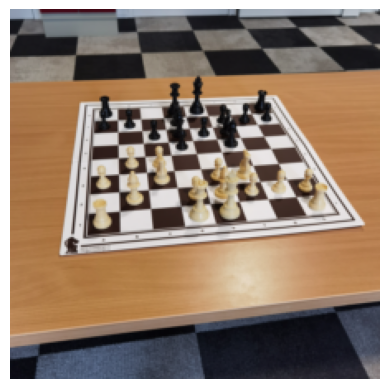

 67%|██████▋   | 2/3 [00:00<00:00,  5.65it/s]

['-', 'K', '-', 'R', '-', '-', '-', 'R']
['b', 'P', 'P', '-', 'K', '-', 'B', '-']
['-', '-', '-', 'P', 'Q', 'K', '-', 'P']
['-', '-', '-', '-', 'P', '-', 'P', '-']
['-', '-', '-', '-', 'p', '-', '-', '-']
['p', '-', 'k', '-', '-', 'p', '-', 'p']
['-', 'p', 'p', 'q', 'k', '-', 'p', '-']
['-', 'k', '-', 'r', '-', '-', '-', 'r']
Test : torch.Size([8, 8, 13])
['P', '-', 'R', '-', 'Q', 'B', '-', 'R']
['P', 'B', '-', 'P', 'P', 'P', 'P', '-']
['-', 'P', 'K', '-', 'P', '-', '-', '-']
['-', '-', 'P', '-', '-', '-', 'P', '-']
['-', '-', '-', 'P', 'p', 'p', '-', '-']
['-', 'p', '-', 'p', '-', 'P', '-', '-']
['p', 'b', 'p', 'k', '-', '-', 'P', 'P']
['-', 'k', 'P', '-', 'q', 'b', 'P', 'P']


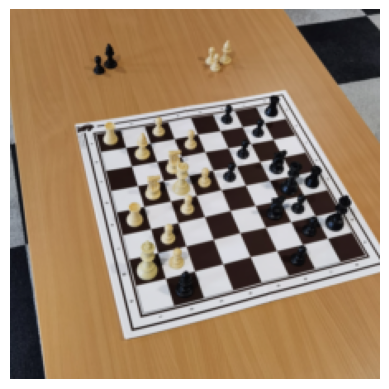

100%|██████████| 3/3 [00:00<00:00,  5.71it/s]


In [ ]:
torch.cuda.empty_cache()
def results_analyse(dataloader):
    preds = []
    labels = []
    tests = 5
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)

        #probs = F.softmax(pred, dim=1)
        #final_pred = torch.argmax(probs, dim=1)
        print_readable_board(y[0])
        print("Test :",pred[0].view( 8, 8, 13).shape)
        print_readable_board(pred[0].view( 8, 8, 13))
        imgs = X.cpu()
        imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
        plt.imshow(imgs[0])
        plt.axis('off')
        plt.show()
        tests -= 1
        if tests < 0:
            break
results_analyse(test_dataloader)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?